In [18]:
#import libraries

import tensorflow as tf
import numpy as np
from keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt
import math as mt
from tensorflow import keras
from keras import layers
import os
import keras.backend as k
import logomaker as lm

In [12]:
# Générer une séquence d'ADN à partir du modèle
modelgen = load_model('/home/florian/projet/generators/generatorRL.h5', compile=False)
seq_generated = modelgen.predict(tf.random.normal((1, 1)))
model_name='new_cut_2001_KC_G'
modelpredict = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
seq_predicted = modelpredict.predict(seq_generated)
del modelgen, modelpredict

1/1 [==============================] - 0s 50ms/step


In [6]:
seq_generated,seq_predicted

(array([[[0.24988578, 0.24988578, 0.24988578, 0.25034267],
         [0.25146943, 0.24893247, 0.25066563, 0.24893247],
         [0.25      , 0.25      , 0.25      , 0.25      ],
         ...,
         [0.25025204, 0.2505054 , 0.2496213 , 0.2496213 ],
         [0.24972644, 0.24972644, 0.24972644, 0.2508207 ],
         [0.25180018, 0.24935949, 0.24948084, 0.24935949]]], dtype=float32),
 array([[2.843621e-07]], dtype=float32))

In [8]:

generator= tf.keras.models.Sequential([
        keras.Input(shape=(1)),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense((40000), activation="relu"),
        tf.keras.layers.Reshape((10000,4)),
        tf.keras.layers.Lambda(lambda x: tf.nn.softmax(x, axis=2))
        ])

class RL(keras.Model):
    def __init__(self, predictor, generator,requested_peak_height,requested_peak_loc):
        super(RL, self).__init__()
        self.predictor = predictor
        self.generator = generator
        self.requested_peak_height=requested_peak_height
        self.requested_peak_loc=requested_peak_loc

    def compile(self, g_optimizer, loss_fn):
        super(RL, self).compile()
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    # @tf.function
    # def maybe_changeLR(self, g_loss):
    #     a=self.g_optimizer.lr.read_value()
    #     print(a)
    #     if g_loss >= self.requested_peak_height/2:
    #         self.g_optimizer.lr.assign(1)
    #     else:
    #         self.g_optimizer.lr.assign(a*tf.math.exp(-0.1))

    #     print(a)

    def train_step(self,_):

        with tf.GradientTape() as tape:
            seq=self.generator(tf.random.normal((1, 1)))[:,self.requested_peak_loc-1000:self.requested_peak_loc+1001]
            predictions = self.predictor(seq)
            g_loss = self.loss_fn(self.requested_peak_height, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        # self.maybe_changeLR(g_loss)
 
        return {"g_loss": g_loss}

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,patience=5, min_lr=0.001)

In [9]:
model_name='new_cut_2001_KC_G'
predictor = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)

rl = RL(predictor=predictor, generator=generator,requested_peak_height=0.8,requested_peak_loc=5000)

rl.compile(g_optimizer=keras.optimizers.Adam(learning_rate=1),
         loss_fn=keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.SUM))

history=rl.fit(tf.random.normal((1, 1)), epochs=50)#, callbacks=[reduce_lr])

Epoch 1/50


2023-05-05 15:48:12.756659: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f3f32ba2490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-05 15:48:12.756674: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-05-05 15:48:12.765091: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-05 15:48:12.867569: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-05 15:48:12.892000: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 1s 733ms/step - g_loss: 0.8000
Epoch 2/50
1/1 [==============================] - 0s 3ms/step - g_loss: 0.8000
Epoch 3/50
1/1 [==============================] - 0s 2ms/step - g_loss: 0.8000
Epoch 4/50
1/1 [==============================] - 0s 2ms/step - g_loss: 0.8000
Epoch 5/50
1/1 [==============================] - 0s 2ms/step - g_loss: 0.8000
Epoch 6/50
1/1 [==============================] - 0s 2ms/step - g_loss: 0.8000
Epoch 7/50
1/1 [==============================] - 0s 2ms/step - g_loss: 0.8000
Epoch 8/50
1/1 [==============================] - 0s 2ms/step - g_loss: 0.8000
Epoch 9/50
1/1 [==============================] - 0s 3ms/step - g_loss: 0.8000
Epoch 10/50
1/1 [==============================] - 0s 3ms/step - g_loss: 0.8000
Epoch 11/50
1/1 [==============================] - 0s 4ms/step - g_loss: 0.8000
Epoch 12/50
1/1 [==============================] - 0s 5ms/step - g_loss: 0.8000
Epoch 13/50
1/1 [==============================] - 0s 3ms/

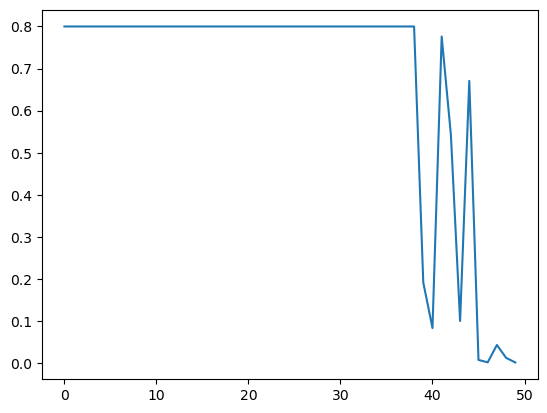

In [10]:
hist_df = pd.DataFrame(history.history) 
plt.plot(hist_df,label='loss')

In [49]:
seq1=rl.generator(tf.constant([0.1]))
seq2=rl.generator(tf.constant([0.9]))

In [12]:
def fast_pred(input,model):
    return model(tf.cast(input,tf.float32))

def fast_pred_seq(input,window_start,model,size=2001):
    X=[]
    for i in range(window_start,window_start+size):
        X.append(np.array(fast_pred(input[:,i-(size//2):i+(size//2)+1],model))[0])
    return(X)

def fast_pred_whole_seq(input,model,size=2001):
    X=[]
    length=len(np.array(input[0]))
    for i in range(size//2,length-(size//2),10):
        X.append(np.array(fast_pred(input[:,i-(size//2):i+(size//2)+1],model))[0])
    return([0 for i in range(0,size//2,10)] + X +[0 for i in range(0,size//2,10)])

In [17]:
L=fast_pred_seq(seq,window_start=4000,model=predictor,size=2001)

In [360]:
Lfull=fast_pred_whole_seq(seq,model=predictor)

In [19]:
Lfull1=fast_pred_whole_seq(seq1,model=predictor)
Lfull2=fast_pred_whole_seq(seq2,model=predictor)

/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


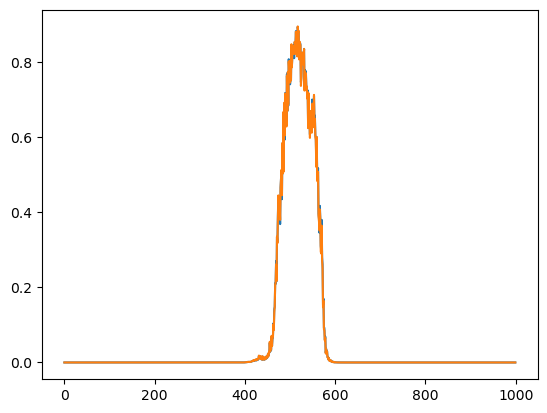

In [20]:
plt.plot(Lfull1)
plt.plot(Lfull2)

In [61]:
seq1,seq2

(<tf.Tensor: shape=(1, 10000, 4), dtype=float32, numpy=
 array([[[0.29096353, 0.23528711, 0.23528711, 0.23846225],
         [0.2284247 , 0.2465257 , 0.23974851, 0.2853011 ],
         [0.24886386, 0.24886386, 0.24886386, 0.25340843],
         ...,
         [0.24158771, 0.2538151 , 0.24158771, 0.2630095 ],
         [0.24486396, 0.27335063, 0.23215218, 0.24963328],
         [0.25757158, 0.26343003, 0.22679976, 0.25219864]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 10000, 4), dtype=float32, numpy=
 array([[[0.29070714, 0.23643096, 0.23643096, 0.23643096],
         [0.23545791, 0.2535034 , 0.23562671, 0.27541193],
         [0.24857995, 0.24857995, 0.24857995, 0.2542601 ],
         ...,
         [0.24369319, 0.25565547, 0.24369319, 0.25695813],
         [0.24278596, 0.26873428, 0.23461801, 0.25386176],
         [0.2606971 , 0.26555744, 0.23001789, 0.24372756]]], dtype=float32)>)

In [9]:
start = 5000
stop = start + 50

In [64]:
# seq=np.array(seq)
# seq=seq.reshape(10000,4)
logo1=pd.DataFrame(np.array(seq1).reshape(10_000,4)[start:stop], columns=["A", "C", "G", "T"])
logo2=pd.DataFrame(np.array(seq2).reshape(10_000,4)[start:stop], columns=["A", "C", "G", "T"])

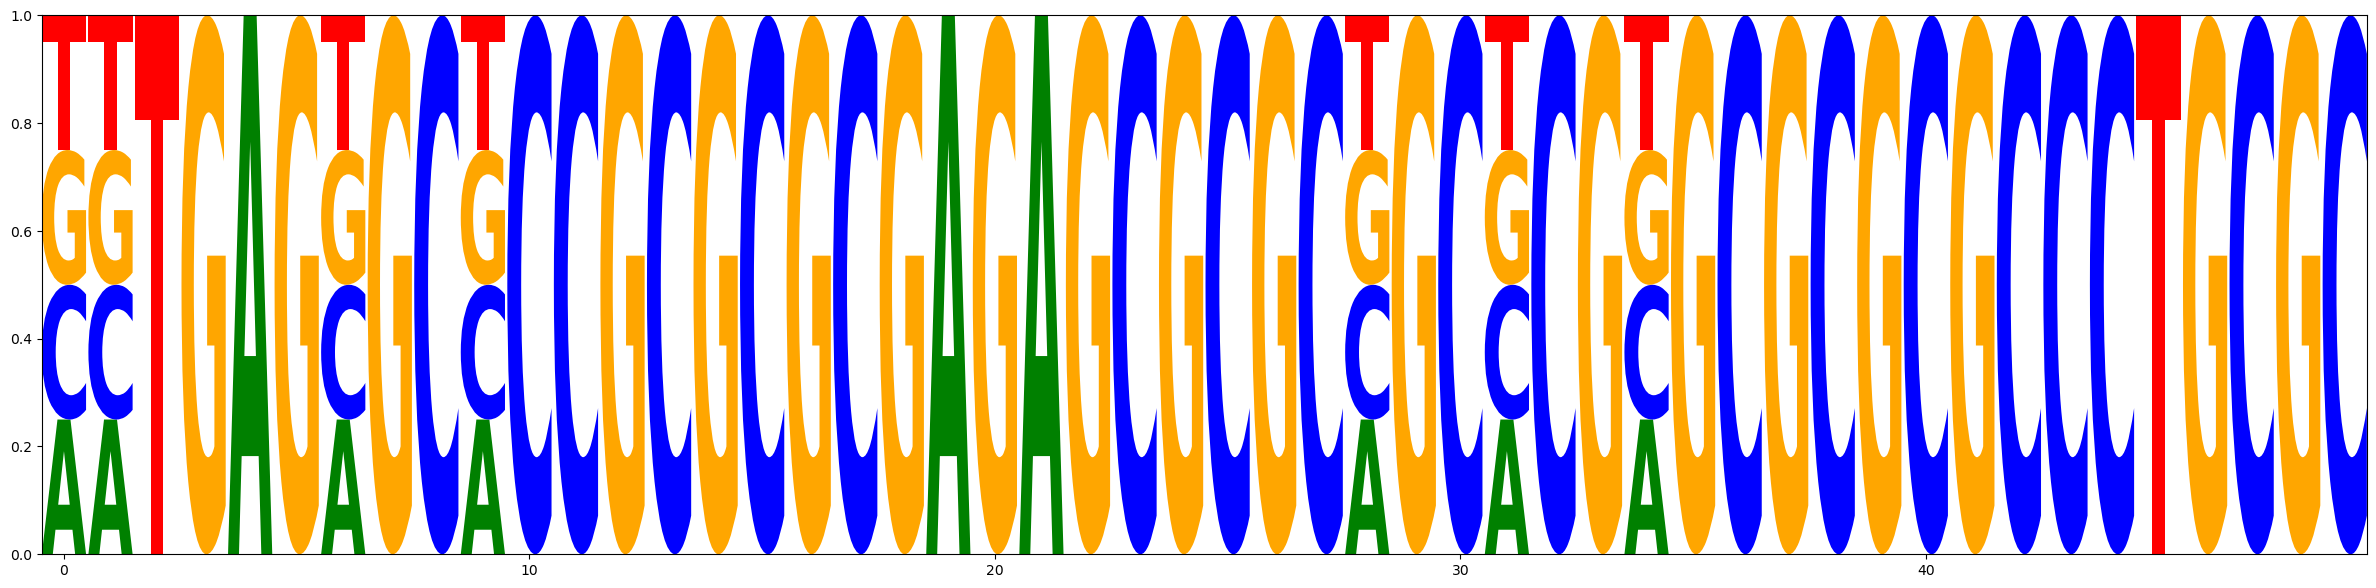

In [65]:
lm.Logo(logo1, figsize=(30, 7))

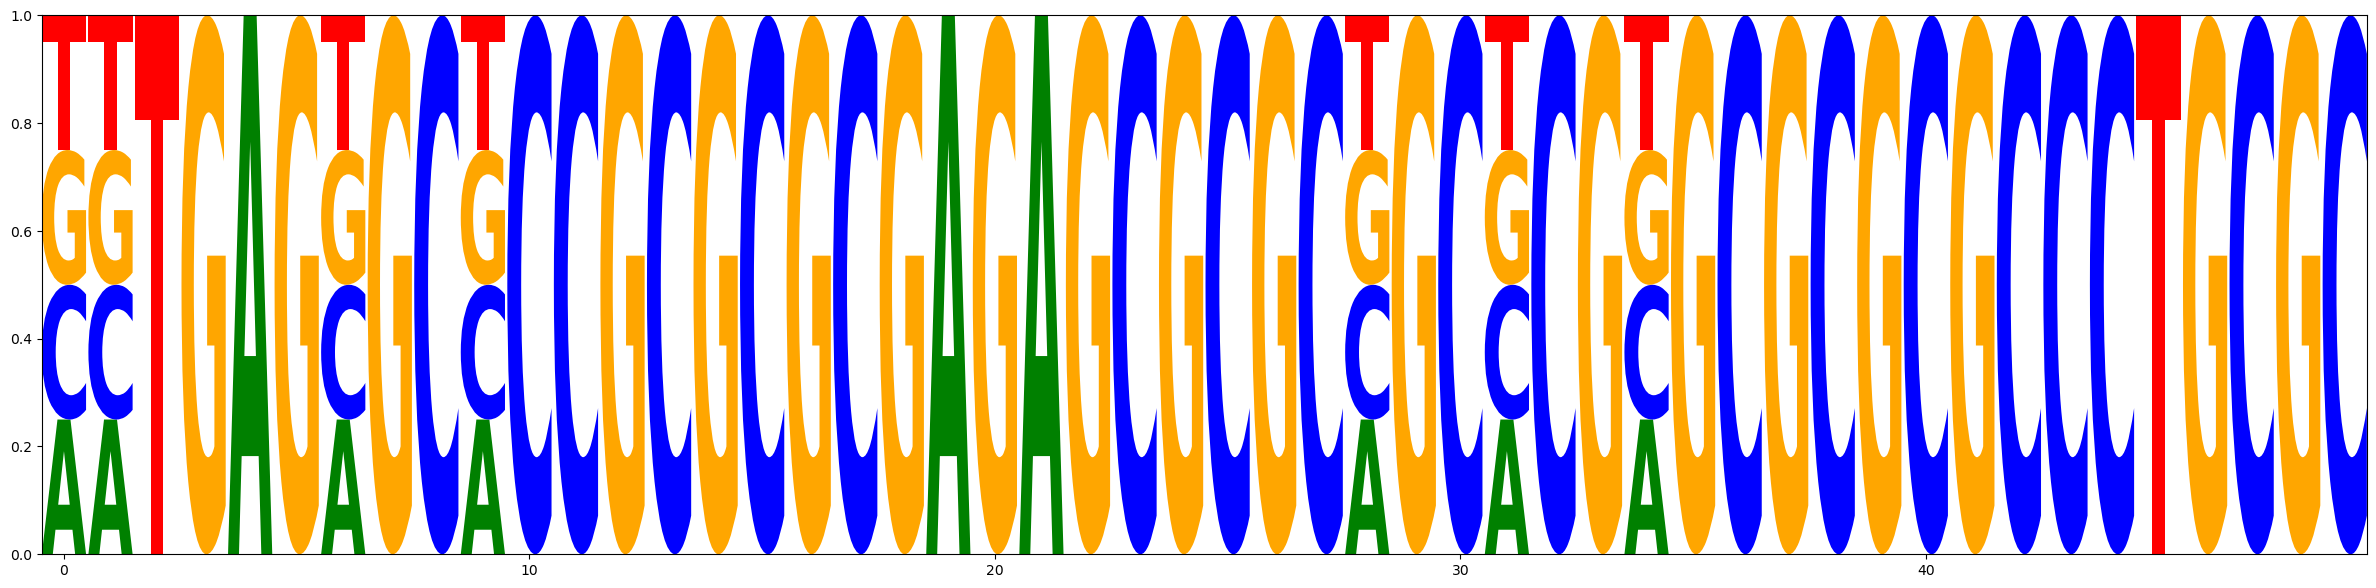

In [66]:
lm.Logo(logo2, figsize=(30, 7))

In [168]:
def seq_entropy(seq):
    X=[]
    for i in seq:
        s=0
        for p in i:
            s+=p*mt.log(p+k.epsilon())
        X.append(s)
    return X

In [169]:
E=seq_entropy(seq1[0])

Text(0.5, 1.0, 'zoom on 4000-6000')

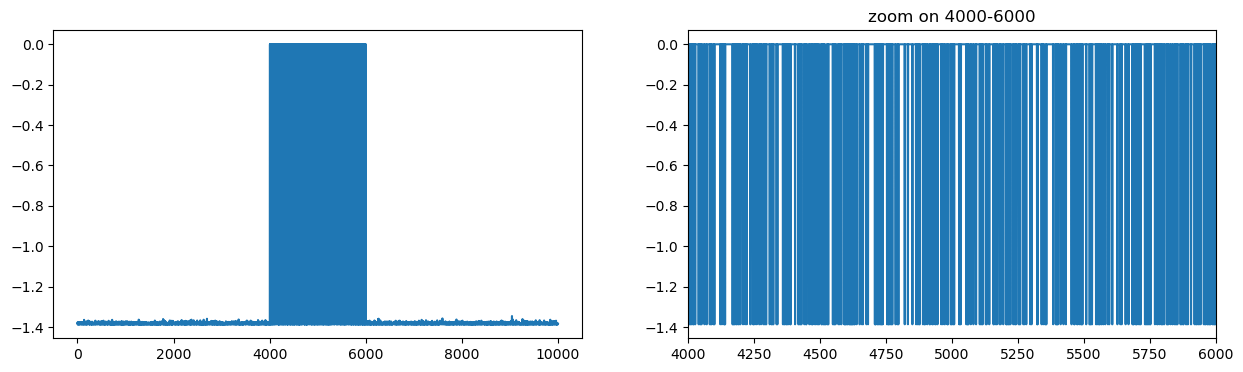

In [171]:
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.plot(E)
plt.subplot(1,2,2)
plt.plot(E)
plt.xlim(4000,6000)
plt.title('zoom on 4000-6000')
# plt.subplot(1,4,4)
# lm.Logo(logo1)

In [1]:
def undifined_rate(seq):
    c=0
    for i in seq:
        if 0.2<max(i)<0.3:
            c+=1
    return(c/len(seq))   

def GC_content(seq):
    c=0
    for i in seq:
        if i == "G":
            c+=1
        elif i == "C":
            c+1
    return (round(c/len(seq)*100,2))

def force_ohe(seq):
    max=0
    for i in range(len(seq)):
        new=[0,0,0,0]
        print(seq[i])
        max=np.max(seq[i])
        if max==0.25:
            new[np.random.randint(0,3)]=1
        else:
            new=np.where(seq[i]==max(seq[i]),1,0)
        seq[i]=new
    return (seq)

In [51]:
np.where(seq_generated[0][2]==max(seq_generated[0][2]),1,0)

array([0, 0, 0, 1])

In [57]:
seq_generated[0]

array([[0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 3.0135051e-37],
       [2.5000000e-01, 2.5000000e-01, 2.5000000e-01, 2.5000000e-01],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       ...,
       [2.5000000e-01, 2.5000000e-01, 2.5000000e-01, 2.5000000e-01],
       [8.1328580e-31, 1.0000000e+00, 8.1328580e-31, 8.1328580e-31],
       [1.0000000e+00, 4.4523377e-26, 4.4523377e-26, 4.4523377e-26]],
      dtype=float32)

In [58]:
force_ohe(seq_generated[0])

[0.0000000e+00 0.0000000e+00 1.0000000e+00 3.0135051e-37]


TypeError: 'numpy.float32' object is not callable

In [4]:
model_name="Wloss"

In [19]:
model_name='new_cut_10LR'

In [5]:
modelgen = load_model('/home/florian/projet/generators/'+model_name+'_G.h5', compile=False)
modeldis = load_model('/home/florian/projet/generators/'+model_name+'_D.h5', compile=False)

2023-05-16 11:54:56.346503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-16 11:54:56.349778: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-16 11:54:56.349871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-16 11:54:56.350364: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

In [6]:
seq_generated = modelgen.predict(tf.random.normal((1, 10)))

2023-05-16 11:54:59.871753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-16 11:55:00.153620: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


1/1 [==============================] - 1s 1s/step


2023-05-16 11:55:00.517438: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [7]:
modeldis.predict(seq_generated)

1/1 [==============================] - 0s 37ms/step


array([[6.6896755e-05]], dtype=float32)

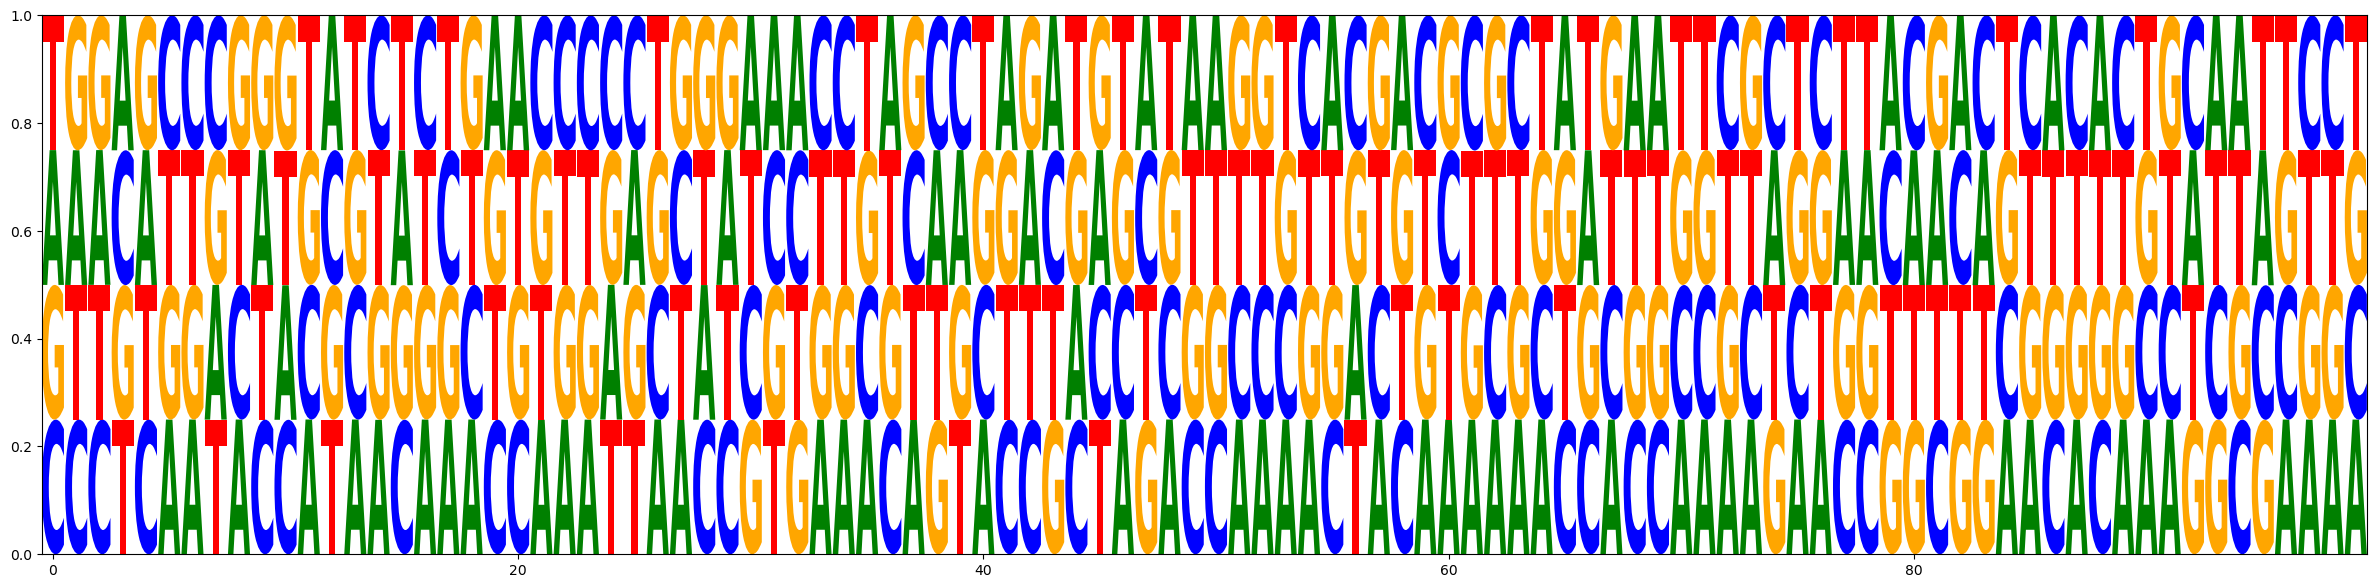

In [8]:
start = 4900
stop = start + 100
logo=pd.DataFrame(np.array(seq_generated).reshape(10_000,4)[start:stop], columns=["A", "C", "G", "T"])
lm.Logo(logo, figsize=(30, 7))

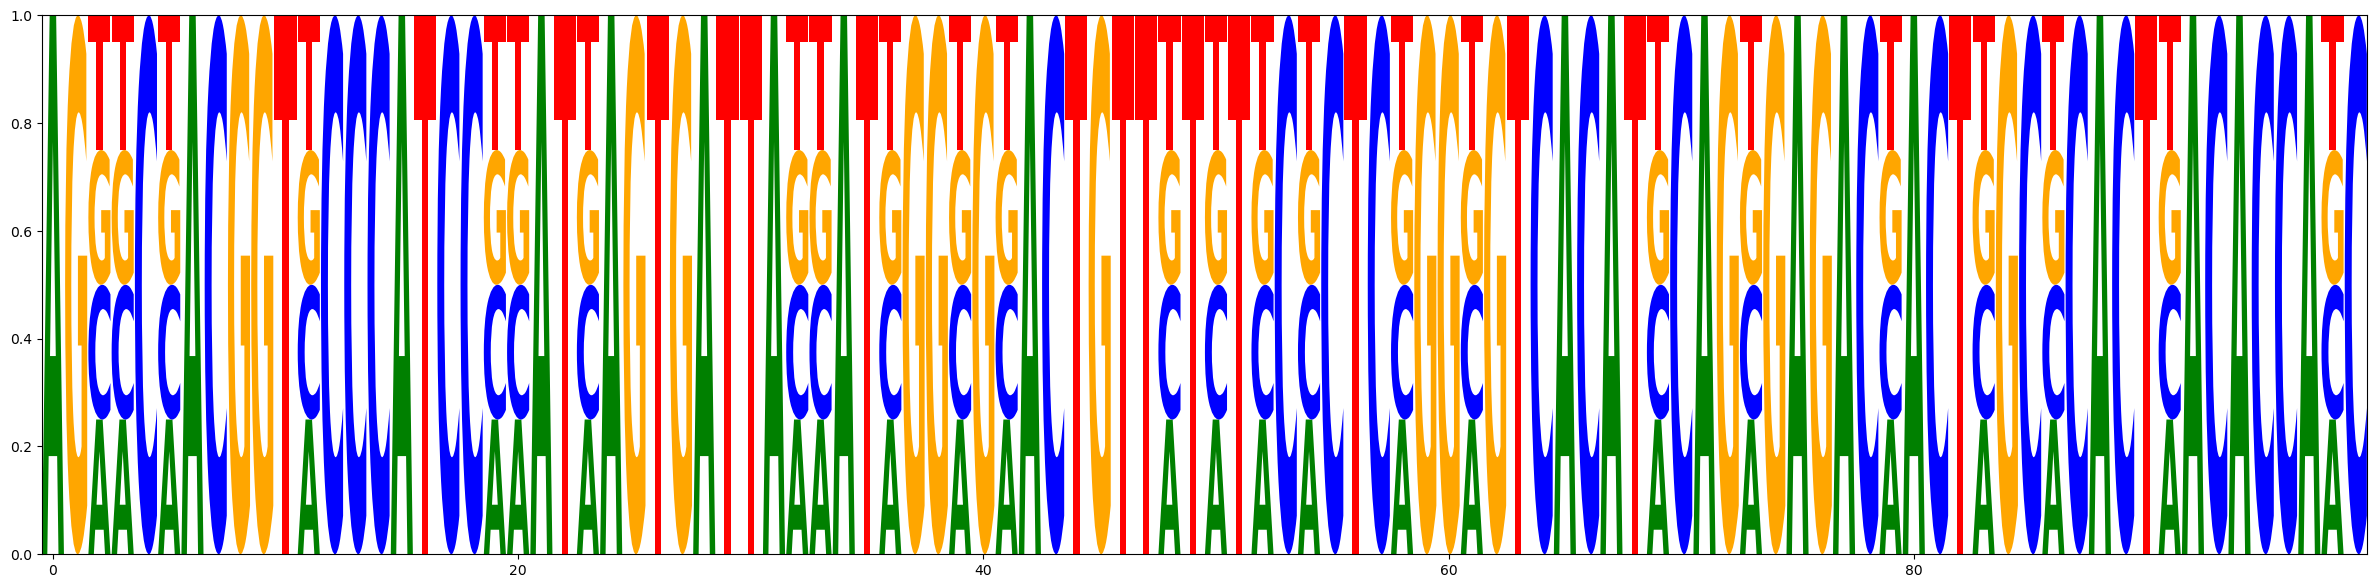

In [9]:
start = 4900
stop = start + 100
logo=pd.DataFrame(np.array(seq_generated).reshape(10_000,4)[start:stop], columns=["A", "C", "G", "T"])
lm.Logo(logo, figsize=(30, 7))

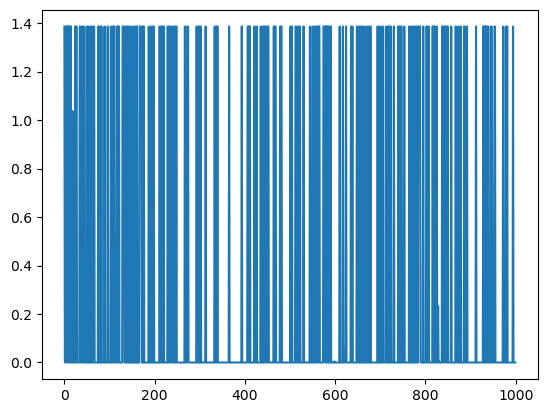

In [10]:
plt.plot(np.sum(-seq_generated*np.log(seq_generated+k.epsilon()), axis=2).ravel()[9000:])

In [9]:
from numpy.lib.stride_tricks import as_strided
def sliding_window_view(x, window_shape, axis = None, *,
                        subok=False, writeable=False):

    window_shape = (tuple(window_shape)
                    if np.iterable(window_shape)
                    else (window_shape,))
    # first convert input to array, possibly keeping subclass
    x = np.array(x, copy=False, subok=subok)

    window_shape_array = np.array(window_shape)
    if np.any(window_shape_array < 0):
        raise ValueError('`window_shape` cannot contain negative values')

    if axis is None:
        axis = tuple(range(x.ndim))
        if len(window_shape) != len(axis):
            raise ValueError(f'Since axis is `None`, must provide '
                             f'window_shape for all dimensions of `x`; '
                             f'got {len(window_shape)} window_shape elements '
                             f'and `x.ndim` is {x.ndim}.')
    else:
        axis = normalize_axis_tuple(axis, x.ndim, allow_duplicate=True)
        if len(window_shape) != len(axis):
            raise ValueError(f'Must provide matching length window_shape and '
                             f'axis; got {len(window_shape)} window_shape '
                             f'elements and {len(axis)} axes elements.')

    out_strides = x.strides + tuple(x.strides[ax] for ax in axis)

    # note: same axis can be windowed repeatedly
    x_shape_trimmed = list(x.shape)
    for ax, dim in zip(axis, window_shape):
        if x_shape_trimmed[ax] < dim:
            raise ValueError(
                'window shape cannot be larger than input array shape')
        x_shape_trimmed[ax] -= dim - 1
    out_shape = tuple(x_shape_trimmed) + window_shape
    return as_strided(x, strides=out_strides, shape=out_shape,
                      subok=subok, writeable=writeable)

In [10]:
with np.load('/home/florian/projet/r6.16/seq.npz') as f:
    X_2L = f['2L']
    X_3R = f['3R']

In [63]:
sliding_window_view(X_2L, (10000, 4)).shape

(23503713, 1, 10000, 4)

In [11]:
for i in [0, 10, 100, 1000, 8000, 9000, 10000, 12000, 20000, 40000]:
    print(i, modeldis.predict(sliding_window_view(X_2L, (10000, 4))[i]))

1/1 [==============================] - 0s 32ms/step
0 [[1.2065313e-05]]
1/1 [==============================] - 0s 9ms/step
10 [[1.2000615e-05]]
1/1 [==============================] - 0s 9ms/step
100 [[1.2000615e-05]]
1/1 [==============================] - 0s 9ms/step
1000 [[1.2065648e-05]]
1/1 [==============================] - 0s 10ms/step
8000 [[1.1878509e-05]]
1/1 [==============================] - 0s 9ms/step
9000 [[1.2408265e-05]]
1/1 [==============================] - 0s 9ms/step
10000 [[1.239567e-05]]
1/1 [==============================] - 0s 9ms/step
12000 [[1.25063825e-05]]
1/1 [==============================] - 0s 9ms/step
20000 [[1.2206474e-05]]
1/1 [==============================] - 0s 10ms/step
40000 [[1.2025131e-05]]


In [12]:
for i in [0, 10, 100, 1000, 8000, 9000, 10000, 12000, 20000, 40000]:
    print(i, modeldis.predict(sliding_window_view(X_3R, (10000, 4))[i]))

1/1 [==============================] - 0s 10ms/step
0 [[1.3131053e-05]]
1/1 [==============================] - 0s 9ms/step
10 [[1.3131053e-05]]
1/1 [==============================] - 0s 9ms/step
100 [[1.3131053e-05]]
1/1 [==============================] - 0s 9ms/step
1000 [[1.3175632e-05]]
1/1 [==============================] - 0s 9ms/step
8000 [[1.2774652e-05]]
1/1 [==============================] - 0s 9ms/step
9000 [[1.2946847e-05]]
1/1 [==============================] - 0s 9ms/step
10000 [[1.3201113e-05]]
1/1 [==============================] - 0s 9ms/step
12000 [[1.3863195e-05]]
1/1 [==============================] - 0s 9ms/step
20000 [[2.7917367e-05]]
1/1 [==============================] - 0s 9ms/step
40000 [[2.7968954e-05]]


In [13]:
undifined_rate(seq_generated[0])

1.0

In [14]:
df = pd.read_csv ('/home/florian/projet/generators/'+model_name+'history.csv')

Text(0.5, 1.0, 'loss values')

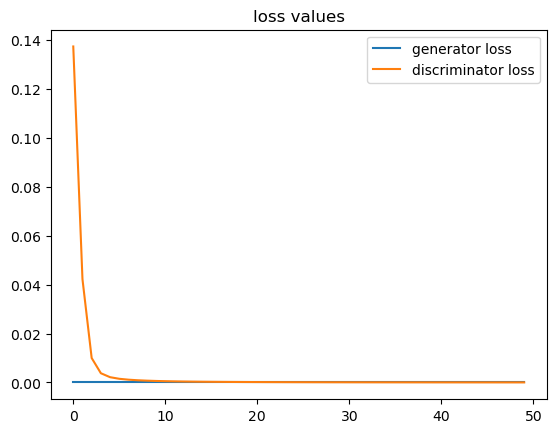

In [15]:
plt.plot(df['g_loss'],label='generator loss')
plt.plot(df['d_loss'],label="discriminator loss")
plt.legend()
# plt.ylim(-100000,100000)
plt.title('loss values')

In [144]:
G_LOSS=[]
D_LOSS=[]
for i in range(len(df['d_loss'])):
    G_LOSS.append([float(v) for s in df['g_loss'][i][:-1].split('\n') for v in s[1:].split()][-1])
    D_LOSS.append([float(v) for s in df['d_loss'][i][:-1].split('\n') for v in s[1:].split()][-1])

IndexError: invalid index to scalar variable.

In [ ]:
plt.plot(G_LOSS,label='generator loss')
plt.plot(D_LOSS,label="discriminator loss")
plt.legend()
plt.title('loss values')

In [16]:
seq_generated1 = modelgen.predict(tf.random.normal((1, 10)))
pred1=modeldis.predict(seq_generated1)
u1=undifined_rate(seq_generated1[0])

seq_generated2 = modelgen.predict(tf.random.normal((1, 10)))
pred2=modeldis.predict(seq_generated2)
u2=undifined_rate(seq_generated2[0])

1/1 [==============================] - 0s 10ms/step


/tmp/ipykernel_482658/812078675.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,1)
/tmp/ipykernel_482658/812078675.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,2)
/tmp/ipykernel_482658/812078675.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,6)


(0.0, 10.0, 0.0, 10.0)

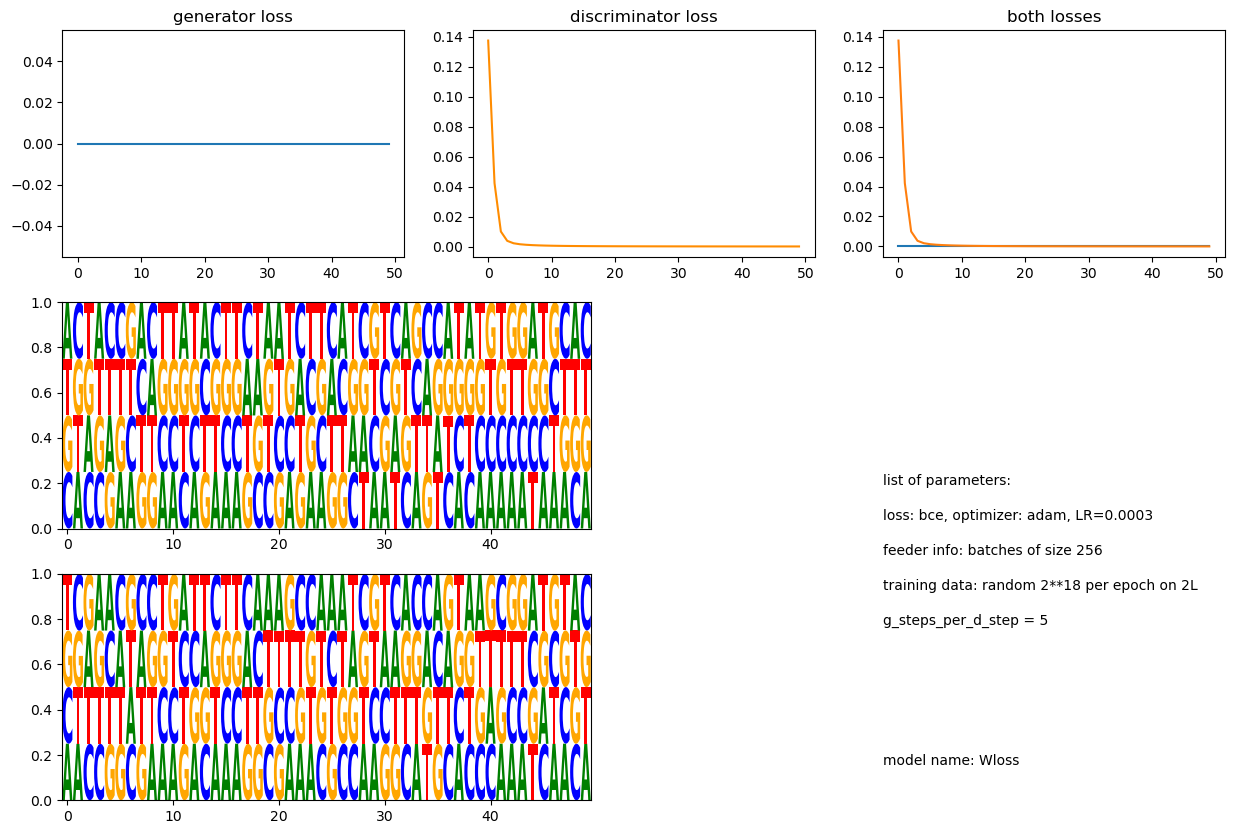

In [17]:
#global plot:
start = 4975
stop= start+50

figs,axes = plt.subplots(3,2,figsize=(15,10))
lm.Logo(pd.DataFrame(np.array(seq_generated1).reshape(10_000,4)[start:stop], columns=["A", "C", "G", "T"]),ax=axes[1,0])
lm.Logo(pd.DataFrame(np.array(seq_generated2).reshape(10_000,4)[start:stop], columns=["A", "C", "G", "T"]),ax=axes[2,0])

plt.subplot(3,3,1)
plt.plot(df['g_loss'])
plt.title("generator loss")
plt.subplot(3,3,2)
plt.plot(df['d_loss'],color='darkorange')
plt.title("discriminator loss")
plt.subplot(3,3,3)
plt.plot(df['g_loss'])
plt.plot(df['d_loss'])
plt.title("both losses")


plt.subplot(2,3,6)
plt.axis([0, 10, 0, 10])
plt.text(0,9,"list of parameters:")
plt.text(0,8,"loss: bce, optimizer: adam, LR=0.0003 ")
plt.text(0,7,"feeder info: batches of size 256")
plt.text(0,6,"training data: random 2**18 per epoch on 2L")
plt.text(0,5,"g_steps_per_d_step = 5")
plt.text(0,4," ")
plt.text(0,3," ")
plt.text(0,2," ")
plt.text(0,1,"model name: " + model_name)
plt.text(0,0," ")
plt.axis("off")